In [1]:
!pip install 'monai [all]'
!pip install antspyx
!pip install antspynet
!pip install nilearn
!pip install dicom2nifti


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 84.4 MB/s eta

In [2]:
from monai.config import print_config

import torch
import matplotlib.pyplot as plt
import monai
import os
from monai.networks.nets import SwinUNETR
from functools import partial
import einops
from einops import rearrange
import numpy as np
import nibabel as nib
print_config()

import ants
import numpy
import antspynet
from antspynet.utilities import brain_extraction
import nilearn
from nilearn import plotting
import nibabel
import dicom2nifti


MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
dicom_path = 'path_to_dicom_file'
model_path = 'path_to_model_weights'
output_path = 'path_to_output_file'

In [3]:
dicom_path = '/content/drive/MyDrive/brats/PGBM-007/02-17-1994-NA-MR RCBV SEQUENCE-FH-22790/36419.000000-FLAIRreg-62309'
model_path = '/content/drive/MyDrive/model_400e_flair.pt'
output_path = '/content/result.nii.gz'

In [6]:
nifti_path = '/content/'
dicom2nifti.convert_directory(dicom_path, nifti_path)

Resize scan to 128x128x128

In [10]:
from nilearn.image import resample_img

target_shape = np.array((128, 128, 128))
new_resolution = [2,]*3
new_affine = np.zeros((4,4))
new_affine[:3,:3] = np.diag(new_resolution)
new_affine[:3,3] = target_shape*new_resolution/2.*-1
new_affine[3,3] = 1.
resampled = resample_img(nibabel.load('/content/36419_flair_reg.nii.gz'), target_affine=new_affine, target_shape=target_shape, interpolation='nearest')

nibabel.save(resampled, '/content/resampled.nii.gz')

Perform brain extraction

In [12]:
preprocessed_img = '/content/masked_brain.nii.gz'
raw_img_path = '/content/resampled.nii.gz'
raw_img_ants = ants.image_read(raw_img_path, reorient='IAL')

prob_brain_mask = brain_extraction(raw_img_ants,modality='flair', verbose=True)

brain_mask = ants.get_mask(prob_brain_mask, low_thresh=0.5)
masked = ants.mask_image(raw_img_ants, brain_mask)

masked_brain = ants.to_nibabel(masked)
nib.save(masked_brain, preprocessed_img)

Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 0s 408ms/step
Brain extraction:  renormalize probability mask to native space.


Define model and test transforms

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)



test_files = [{"image": [preprocessed_img, preprocessed_img, preprocessed_img, preprocessed_img]}]
test_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=["image"]),
        monai.transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = monai.data.Dataset(data=test_files, transform=test_transform)

test_loader = monai.data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

Perform inference

In [14]:
model.load_state_dict(torch.load(model_path)["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    monai.inferers.sliding_window_inference,
    roi_size=[128, 128, 128],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

        #nib.save(nib.Nifti1Image(seg_out.astype(np.uint8), affine), './mask.nii.gz')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



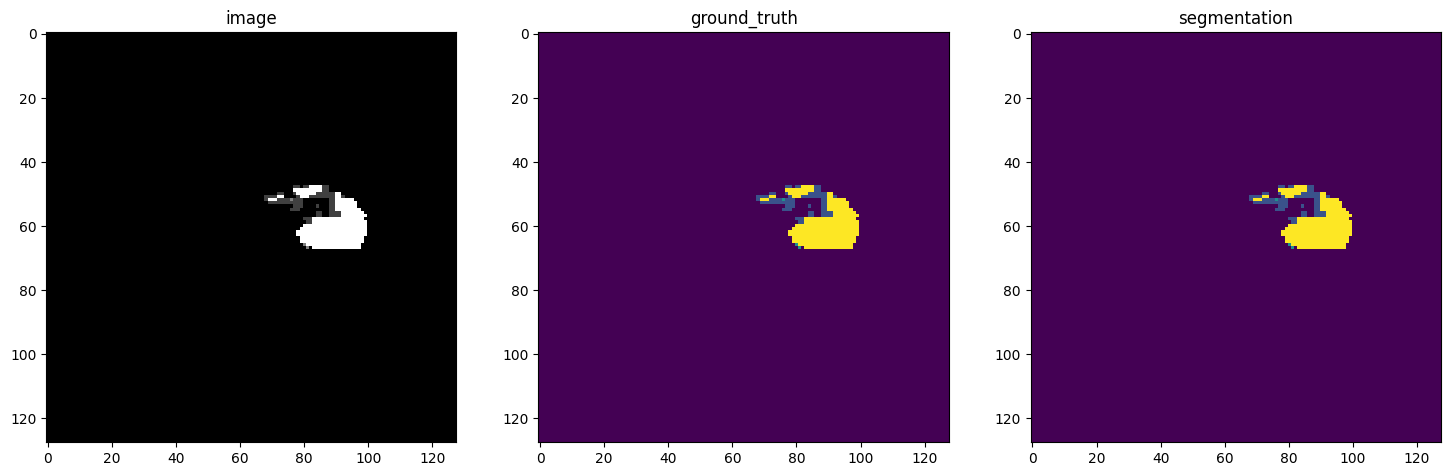

In [26]:
slice_num = 83



plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(seg_out[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("ground_truth")
plt.imshow(seg_out[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

# Save model prediction to DICOM

In [ ]:
!nii2dcm nifti-file.nii.gz dicom-output-directory/ -d MR